In [2]:
import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

import numpy as np
import matplotlib.pyplot as plt
import torch

import pyro
from pyro import poutine
from pyro import distributions as dist
from pyro_oed_src import posterior_loss
from pyro.contrib.util import lexpand, rexpand

from nflows.transforms import made as made_module
import neural_nets
import flows

from astropy.cosmology import Planck18
from astropy.cosmology import FLRW, w0waCDM
from astropy import constants

from scipy.interpolate import interp1d
import time 
import scipy.stats

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

#set default dtype
torch.set_default_dtype(torch.float64)

Using device: cuda:0.


In [4]:
np_dtype = np.float64
redshifts = np.round(np.arange(0.05, 3.6, 0.05, dtype=np_dtype), 2)
designs = torch.tensor(redshifts).to(device).unsqueeze(-1)
designs[0:5]

tensor([[0.0500],
        [0.1000],
        [0.1500],
        [0.2000],
        [0.2500]], device='cuda:0')

In [5]:
c = constants.c.to('km/s').value
r_drag = 147.55

cosmo = w0waCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, Ode0=Planck18.Ode0, Neff=Planck18.Neff, m_nu=Planck18.m_nu, w0=-1, wa=0)
# add N_eff and m_nu and use w0wa
# check present day omega sum to 1 for planck18
print("Energy density of matter today: ", cosmo.Om0)
print("Energy density of dark energy today: ", cosmo.Ode0)
print("Hubble constant today: ", cosmo.H0)
print("Energy density of radiation today: ", cosmo.Ogamma0 + cosmo.Onu0)
print("Curvature of universe today: ", cosmo.Ok0)
Om = cosmo.Om0
Ode = cosmo.Ode0
H0 = cosmo.H0.value
Orad = cosmo.Ogamma0 + cosmo.Onu0
Ok = cosmo.Ok0

coeff = c/(H0*r_drag)

Energy density of matter today:  0.30966
Energy density of dark energy today:  0.6888463055445441
Hubble constant today:  67.66 km / (Mpc s)
Energy density of radiation today:  0.0014936944554559178
Curvature of universe today:  -3.2742905609062234e-17


In [6]:
# 2D Hubble Distance equation
def D_H_func(z, Om=Om, w0=-1, Ode=Ode, wa=0):
    return coeff/torch.sqrt(Om*(1+z)**3 + (1-Om-Ode)*(1+z)**4 + Ode*(1+z)**(3*(1+(w0+wa*z/(1+z))))).to(device)

def h(z, y, Om, w0, sig_Om, sig_w0, Ode=Ode):
    return (-coeff + y * torch.sqrt(Ode*(1+z)**(3+3*w0) - (1+z)**3*(-1+Ode+(-1+Ode+Om)*z)))/(torch.sqrt(Ode * (1+z)**(3+3*w0) - 
    (1+z)**3 * (-1 + Ode + (-1+Ode+Om)*z)) * torch.sqrt((225.444 * sig_Om**2 * z**2 * (1+z)**6 + 2029 * Ode**2 * sig_w0**2 * (1+z)**(6+6*w0) * torch.log(1+z)**2)/(Om * (1+z)**3 -
    (-1 + Ode + Om) * (1+z)**4 + Ode * (1+z)**(3+3*w0))**3))

def sig_h(z, sig_y, Om, w0, sig_Om, sig_w0, Ode=Ode):
    return sig_y/torch.sqrt((225.444 * sig_Om**2 * z**2 * (1+z)**6 + 2029 * Ode**2 * sig_w0**2 * (1+z)**(6+6*w0) * torch.log(1+z)**2)/(Om * (1+z)**3 -
    (-1 + Ode + Om) * (1+z)**4 + Ode * (1+z)**(3+3*w0))**3)

def output(z, h_out, Om, w0, sig_Om, sig_w0, Ode=Ode):
    return (coeff + h_out * torch.sqrt(Om * (1+z)**3 - (-1 + Ode +Om) * (1+z)**4 + Ode * (1+z)**(3+3*w0)) * torch.sqrt((225.444 * sig_Om**2 * z**2 * (1+z)**6 + 
    2029 * Ode**2 * sig_w0**2 * (1+z)**(6+6*w0) * torch.log(1+z)**2)/(Om * (1+z)**3 - (-1 + Ode + Om) * (1+z)**4 + Ode * (1+z)**(3+3*w0))**3))/torch.sqrt(Om * (1+z)**3 -
    (-1 + Ode + Om) * (1+z)**4 + Ode * (1+z)**(3+3*w0))

def sig_output(z, sig_out, Om, w0, sig_Om, sig_w0, Ode=Ode):
    return sig_out*torch.sqrt((225.444 * sig_Om**2 * z**2 * (1+z)**6 + 2029 * Ode**2 * sig_w0**2 * (1+z)**(6+6*w0) * torch.log(1+z)**2)/(Om * (1+z)**3 -
    (-1 + Ode + Om) * (1+z)**4 + Ode * (1+z)**(3+3*w0))**3)

In [7]:
class GP_Kernels:
    def __init__(self, se_sigma=0.05, se_l=10.0, poly_sigma=1.0, poly_degree=3):
        self.se_sigma = se_sigma
        self.se_l = se_l
        self.poly_sigma = poly_sigma
        self.poly_degree = poly_degree

    def se_kernel(self, a, b):
        # squared exponential kernel
        sqdist = torch.sum(a**2,axis=-1).unsqueeze(-1) + torch.sum(b**2,axis=-1).unsqueeze(-2) - 2*torch.matmul(a, b.transpose(-2,-1))
        return self.se_sigma**2*torch.exp(-(1/2) * (1/self.se_l**2) * sqdist)
    
    def poly_kernel(self, a, b):
        # polynomial kernel
        return (self.poly_sigma + torch.matmul(a, b.transpose(-2,-1)))**self.poly_degree

def get_levels(data, percentiles):
    sorted_data = np.sort(data.ravel())[::-1]
    # Calculate the cumulative sum of the sorted values
    cumsum_data = np.cumsum(sorted_data)
    levels = []
    for p in percentiles:
        # Find the level where the cumulative sum is p% of the total sum
        level_p = sorted_data[np.where(cumsum_data <= cumsum_data[-1] * p/100)[0][-1]]
        levels.append(level_p)
    return levels

In [17]:
# prior observations
z_1 = 0.698 # LRGs
z_2 = 2.33 # Lyman-alpha

# hubble distance measurements
y_h1 = 19.77 # D_H_func(torch.tensor(z_1)).item() # 19.77
sig_h1 = 0.47 # 0.001 # 0.47
y_h2 = 8.99 # D_H_func(torch.tensor(z_2)).item() # 8.99
sig_h2 = 0.17 # 0.001 # 0.17

# angular diameter distance measurements
y_a1 = 17.65
sig_a1 = 0.30
y_a2 = 37.5
sig_a2 = 1.1

In [18]:
context_size = 2 # number of context/conditioning variables (design variables + observations)
posterior_dims = 2 # num of parameters in posterior distribution

num_blocks = 3 # number of blocks in the flow
num_transforms = 3 # number of transformations
hidden_features = 32 # number of hidden features in the flow

hyper_nn_args = {"context_features": context_size,
                "hidden_features": hidden_features,
                "num_blocks": num_blocks,
                "activation": torch.nn.ReLU(),
                "use_residual_blocks": False,
                "random_mask": False} # use a random mask for the MADE network
base_nn_args = {"type": "dense",
                "context_size": context_size,
                "hidden_dims": num_blocks*[hidden_features],
                "n_params": posterior_dims + posterior_dims + int(posterior_dims*(posterior_dims-1)/2), # number of parameters to output (65 for posterior_dim = 10)
                "nonlinearity": torch.nn.ReLU()}
flow_args = {"n_dims": posterior_dims, 
            "n_transforms": num_transforms, # number of transforms in the flow
            "hyper_type": "conditional_dense", # type of transformation network
            "hyper_args": hyper_nn_args, # arguments for transformation network
            "base_type": "conditional_normal", # type of base distribution
            "base_args": base_nn_args} # arguments for the base distribution

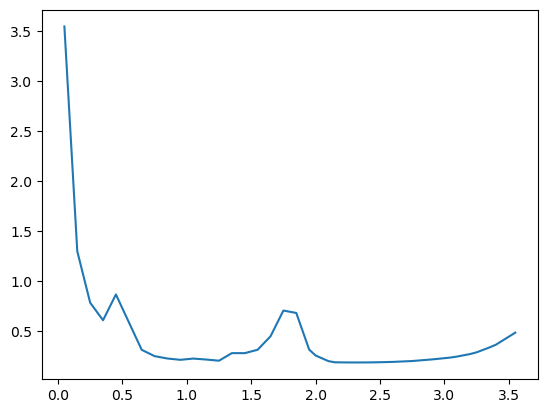

In [19]:
bgs_redshifts = torch.tensor([0.05, 0.15, 0.25, 0.35, 0.45])
lrg_redshifts = torch.arange(0.65, 1.95, 0.1)
lyman_alp_redshifts = torch.tensor([1.96, 2.12, 2.28, 2.43, 2.59, 2.75, 2.91, 3.07, 3.23, 3.39, 3.55])
error_redshifts = torch.cat([bgs_redshifts, lrg_redshifts, lyman_alp_redshifts])
H_errors = torch.tensor([12.10, 4.66, 2.97, 2.44, 3.69, 1.50, 1.27, 1.22, 1.22, 1.37, 1.39, 1.39, 2.02, 2.13, 2.52, 3.80, 6.30, 6.39, 2.74, 1.99, 2.11, 2.26, 2.47, 2.76, 3.18, 3.70, 4.57, 6.19, 8.89], device=device)/100
D_H = D_H_func(error_redshifts)
D_H_error = H_errors*D_H
D_H_error_func = interp1d(error_redshifts, D_H_error.cpu().numpy(), kind='linear')

plt.plot(designs.cpu().numpy(), D_H_error_func(designs.cpu().numpy()))
plt.show()

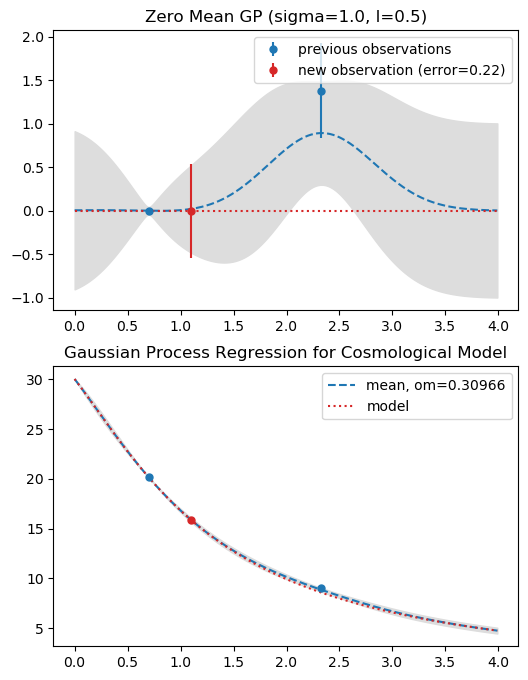

In [16]:
se_l = 0.5 # smoothness parameter
se_sigma = 1.0 # thickness parameter
poly_degree = 1.0 # degree of polynomial kernel
poly_sigma = 2.0
data = torch.tensor([z_1, z_2, y_h1, y_h2, sig_h1, sig_h2], device=device, dtype=torch.float64).reshape(3,2)
kernels = GP_Kernels(se_sigma=se_sigma, se_l=se_l, poly_sigma=poly_sigma, poly_degree=poly_degree)

kernel = kernels.se_kernel
    
om = torch.tensor([cosmo.Om0], device=device).reshape(-1, 1) # Gaussian prior mean
w0 = torch.tensor([cosmo.w0], device=device).reshape(-1, 1) # Gaussian prior mean
sig_Om = torch.tensor(0.01, device=device) # prior uncertainty of Omega_m
sig_w0 = torch.tensor(0.1, device=device) # prior uncertainty of w0

z_val = round(1.1,2)
new_z = torch.tensor(z_val, device=device)
prev_z = data[0]
X = torch.concat((prev_z, new_z.unsqueeze(0)), dim=0)
X = X.repeat(len(om), 1).unsqueeze(-1) # shape: (batch_size, 2)

new_y = D_H_func(new_z, om.squeeze(), w0.squeeze())
prev_y = data[1]
measured_y = torch.concat((prev_y, new_y.unsqueeze(0)), dim=0)
zero_y = h(X.squeeze(), measured_y, om, w0, sig_Om, sig_w0) # zero mean

new_error = torch.tensor(D_H_error_func(z_val), device=device).unsqueeze(0)
prev_error = data[2]
y_error = torch.concat((prev_error, new_error), dim=0)
zero_error = sig_h(X.squeeze(), y_error.squeeze(), om, w0, sig_Om, sig_w0) # zero mean

K = kernel(X, X) # shape: (N, N)
L = torch.linalg.cholesky(K + zero_error.unsqueeze(-1)*torch.eye(X.shape[1], device=device)) # add zeroed error, (line 1 of https://arxiv.org/pdf/2009.10862.pdf)

# points we're going to make predictions at.
X_test = torch.arange(0, 4, 0.01).to(device) # shape: (M,1), M = number of test points
X_test = X_test.repeat(len(om), 1).unsqueeze(-1)

# compute the mean at our test points.
Lk = torch.linalg.solve(L, kernel(X, X_test))  # k_star = kernel(X, X_test), calculating v := l\k_star (line 4), shape: (batch_size, N, M)
mu = torch.matmul(Lk.transpose(1,2), torch.linalg.solve(L, zero_y.unsqueeze(-1)))    # \alpha = np.linalg.solve(L, y), (lines 2 and 3), shape: (batch_size, M, 1)

# compute the variance at our test points.
K_ = kernel(X_test, X_test)        # k(x_star, x_star)
s2 = torch.diagonal(K_, dim1=1, dim2=2) - torch.sum(Lk**2, axis=1) # s2 = k_star_star - np.einsum("ij,ij->j", v, v) (line 5), shape: (batch_size, M)
s = torch.sqrt(s2)

mean_pred = output(X_test.squeeze(), mu.squeeze(), om, w0, sig_Om, sig_w0)
error_pred = sig_output(X_test.squeeze(), s.squeeze(), om, w0, sig_Om, sig_w0)
fig1, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
colors = ["tab:blue", "tab:orange", "tab:green"]
for i in range(len(om)):
    next_color = colors.pop(0)
    ax1.errorbar(
        X.squeeze(-1)[i,:-1].cpu(),
        zero_y[i,:-1].cpu(),
        zero_error[i,:-1].cpu(),
        linestyle="None",
        color=next_color,
        marker=".",
        markersize=10,
        label="previous observations"
    )
    ax1.errorbar(
        X[i,-1].cpu(),
        zero_y[i,-1].cpu(),
        zero_error[i,-1].cpu(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=10,
        label=f"new observation (error={new_error.squeeze().item():.2f})",
    )
    ax1.plot(X_test[i].cpu(), mu[i].cpu(), linestyle='--', color=next_color)
    ax1.fill_between(
        X_test[i].squeeze().cpu(),
        mu[i].squeeze().cpu() - s[i].squeeze().cpu(),
        mu[i].squeeze().cpu() + s[i].squeeze().cpu(),
        color="#dddddd",
    )
ax1.plot(X_test[i].cpu(), torch.zeros(len(X_test[i])).cpu(), linestyle=':', color="tab:red")
ax1.legend()
ax1.set_title(f'Zero Mean GP (sigma={se_sigma}, l={se_l})')
colors = ["tab:blue", "tab:orange", "tab:green"]
for i in range(len(om)):
    next_color = colors.pop(0)
    ax2.errorbar(
        X.squeeze(-1)[i,:-1].cpu(),
        measured_y[:-1].cpu(),
        y_error[:-1].cpu(),
        linestyle="None",
        color=next_color,
        marker=".",
        markersize=10,
    )
    ax2.errorbar(
        X[i][-1].cpu(),
        measured_y[-1].cpu(),
        y_error[-1].cpu(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=10,
    )
    ax2.plot(X_test[i].cpu(), mean_pred[i].cpu(), linestyle='--', color=next_color, label=f'mean, om={om[i].item()}')
    ax2.fill_between(
        X_test[i].squeeze().cpu(),
        mean_pred[i].squeeze().cpu() - error_pred[i].squeeze().cpu(),
        mean_pred[i].squeeze().cpu() + error_pred[i].squeeze().cpu(),
        color="#dddddd",
    )
ax2.plot(X_test[i].cpu(), D_H_func(X_test).squeeze().cpu(), linestyle=':', color="tab:red", label=f'model')
ax2.set_title('Gaussian Process Regression for Cosmological Model')
ax2.legend()
plt.show()

tensor([0.1850], device='cuda:0')


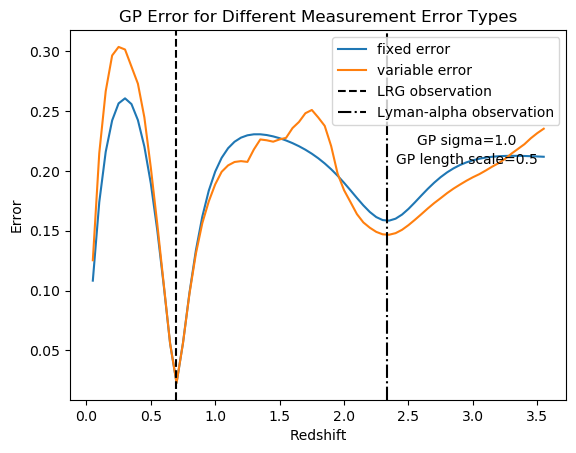

In [12]:
se_l = 0.5 # smoothness parameter
se_sigma = 1.0 # thickness parameter
poly_degree = 5.0 # degree of polynomial kernel
poly_sigma = 0.5 
data = torch.tensor([z_1, z_2, y_h1, y_h2, sig_h1, sig_h2], device=device, dtype=torch.float64).reshape(3,2)
kernels = GP_Kernels(se_sigma=se_sigma, se_l=se_l, poly_sigma=poly_sigma, poly_degree=poly_degree)
kernel = kernels.se_kernel

D_H_error_func = interp1d(error_redshifts, D_H_error.cpu().numpy(), kind='linear')

plt.figure()
for error_type in ["fixed", "variable"]:
    new_pt_error = []
    for i in designs:
        om = torch.tensor([cosmo.Om0], device=device).reshape(-1, 1) # Gaussian prior mean
        w0 = torch.tensor([cosmo.w0], device=device).reshape(-1, 1)
        sig_Om = torch.tensor(0.01, device=device) # Gaussian prior std
        sig_w0 = torch.tensor(0.1, device=device) # Gaussian prior std

        z_val = round(i.item(),2)
        new_z = torch.tensor(z_val, device=device)
        prev_z = data[0]
        X = torch.concat((prev_z, new_z.unsqueeze(0)), dim=0)
        X = X.repeat(len(om), 1).unsqueeze(-1) # shape: (batch_size, 2)

        new_y = D_H_func(new_z, om.squeeze(), w0.squeeze())
        prev_y = data[1]
        measured_y = torch.concat((prev_y, new_y.unsqueeze(0)), dim=0)
        zero_y = h(X.squeeze(), measured_y, om, w0, sig_Om, sig_w0) # zeroed mean

        if error_type == "fixed":
            new_error = torch.tensor(0.3, device=device).unsqueeze(0)
        elif error_type == "variable":
            new_error = torch.tensor(D_H_error_func(z_val), device=device).unsqueeze(0)
            if i == 2.35:
                print(new_error)
        prev_error = data[2]
        y_error = torch.concat((prev_error, new_error), dim=0)
        zero_error = sig_h(X.squeeze(), y_error.squeeze(), om, w0, sig_Om, sig_w0) # zeroed mean error

        K = kernel(X, X) # shape: (N, N)
        L = torch.linalg.cholesky(K + zero_error.unsqueeze(-1)*torch.eye(X.shape[1], device=device)) # add zeroed error, (line 1 of https://arxiv.org/pdf/2009.10862.pdf)

        # points we're going to make predictions at.
        X_test = torch.arange(0, 4, 0.01).to(device) # shape: (M,1), M = number of test points
        X_test = X_test.repeat(len(om), 1).unsqueeze(-1)

        # compute the mean at our test points.
        Lk = torch.linalg.solve(L, kernel(X, X_test))  # k_star = kernel(X, X_test), calculating v := l\k_star (line 4), shape: (batch_size, N, M)
        mu = torch.matmul(Lk.transpose(1,2), torch.linalg.solve(L, zero_y.unsqueeze(-1)))    # \alpha = np.linalg.solve(L, y), (lines 2 and 3), shape: (batch_size, M, 1)

        # compute the variance at our test points.
        K_ = kernel(X_test, X_test)        # k(x_star, x_star)
        s2 = torch.diagonal(K_, dim1=1, dim2=2) - torch.sum(Lk**2, axis=1) # s2 = k_star_star - np.einsum("ij,ij->j", v, v) (line 5), shape: (batch_size, M)
        s = torch.sqrt(s2)
        mean_pred = output(X_test.squeeze(), mu.squeeze(), om, w0, sig_Om, sig_w0)
        error_pred = sig_output(X_test.squeeze(), s, om, w0, sig_Om, sig_w0)
        # find the index of the new_zew
        new_pt_error.append(error_pred[:,X_test.cpu().squeeze().numpy().round(2).tolist().index(z_val)].item())


    plt.plot(designs.cpu().numpy(), new_pt_error, label="{} error".format(error_type))
plt.axvline(x=0.698, color='black', linestyle='--', label="LRG observation")
plt.axvline(x=2.330, color='black', linestyle='-.', label="Lyman-alpha observation")
plt.text(0.8, 0.7, "GP sigma={}".format(se_sigma), ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.8, 0.65, "GP length scale={}".format(se_l), ha='center', va='center', transform=plt.gca().transAxes)
plt.title("GP Error for Different Measurement Error Types")
# add text on white background at same relative position
plt.xlabel("Redshift")
plt.ylabel("Error")
plt.legend()
plt.show()

In [13]:
class GPRegressionModel:
    def __init__(self, data, Om_prior, Om_sigma_prior, w0_prior, w0_sigma_prior, kernel, kind, error_type):
        self.data = data
        self.Om_prior = torch.tensor(Om_prior, device=device)
        self.Om_sigma_prior = torch.tensor(Om_sigma_prior, device=device)
        self.w0_prior = torch.tensor(w0_prior, device=device)
        self.w0_sigma_prior = torch.tensor(w0_sigma_prior, device=device)
        self.kernel = kernel
        self.D_H_error_func = interp1d(error_redshifts, D_H_error.cpu().numpy(), kind=kind)
        self.error_type = error_type

    def gp_func(self, designs, om, w0):
        om_shape = om.shape
        #om = om.reshape(-1, 1)
        design_pt_error = []
        for i, d in enumerate(designs[0]):
            om_d = om[:,i] # (n_particles, 1)
            w0_d = w0[:,i] # (n_particles, 1)
            z_val = round(d.item(),2)
            new_z = torch.tensor(z_val, device=device)
            prev_z = self.data[0]
            X = torch.concat((prev_z, new_z.unsqueeze(0)), dim=0)
            X = X.repeat(len(om), 1).unsqueeze(-1) # shape: (batch_size, 2)

            new_y = D_H_func(new_z, om_d, w0_d)
            prev_y = self.data[1]
            prev_y = prev_y.repeat(len(om_d), 1)
            measured_y = torch.concat((prev_y, new_y), dim=-1)
            zero_y = h(X.squeeze(-1), measured_y, om_d, w0_d, self.Om_sigma_prior, self.w0_sigma_prior) # zeroed mean

            if self.error_type == "fixed":
                new_error = torch.tensor(0.3, device=device).unsqueeze(0)
            elif self.error_type == "variable":
                new_error = torch.tensor(self.D_H_error_func(z_val), device=device).unsqueeze(0)
            prev_error = self.data[2]
            y_error = torch.concat((prev_error, new_error), dim=0)
            zero_error = sig_h(X.squeeze(-1), y_error, om_d, w0_d, self.Om_sigma_prior, self.w0_sigma_prior) # zeroed error

            K = self.kernel(X, X) # shape: (N, N)
            L = torch.linalg.cholesky(K + zero_error.unsqueeze(-1)*torch.eye(X.shape[1]).to(device)) # add error, (line 1 of https://arxiv.org/pdf/2009.10862.pdf)

            # points we're going to make predictions at.
            X_test = torch.arange(0.05, 5, 0.05).to(device) # shape: (M,1), M = number of test points
            X_test = X_test.repeat(len(om_d), 1).unsqueeze(-1)

            # compute the mean at our test points.
            Lk = torch.linalg.solve(L, self.kernel(X, X_test))  # k_star = kernel(X, X_test), calculating v := l\k_star (line 4), shape: (batch_size, N, M)
            mu = torch.matmul(Lk.transpose(1,2), torch.linalg.solve(L, zero_y.unsqueeze(-1)))    # \alpha = np.linalg.solve(L, y), (lines 2 and 3), shape: (batch_size, M, 1)

            # compute the variance at our test points.
            K_ = self.kernel(X_test, X_test) # k(x_star, x_star)
            s2 = torch.diagonal(K_, dim1=1, dim2=2) - torch.sum(Lk**2, axis=1) # s2 = k_star_star - np.einsum("ij,ij->j", v, v) (line 5), shape: (batch_size, M)
            s = torch.sqrt(s2)

            # rescale the mean and variance
            mean_pred = output(X_test.squeeze(), mu.squeeze(), om_d, w0_d, self.Om_sigma_prior, self.w0_sigma_prior)
            error_pred = sig_output(X_test.squeeze(), s.squeeze(), om_d, w0_d, self.Om_sigma_prior, self.w0_sigma_prior)
            
            # find the error at the new design point
            design_pt_error.append(error_pred[:,X_test[0].cpu().squeeze().numpy().round(2).tolist().index(z_val)])
        
        design_pt_errors = torch.stack(design_pt_error)
        # rearrange dimensions of design_pt_errors to match the shape of om
        return design_pt_errors.transpose(0,1).unsqueeze(-1)

    def model(self, designs):
        with pyro.plate_stack("plate", designs.shape[:-1]):
            Om = pyro.sample("Om", dist.Normal(self.Om_prior, self.Om_sigma_prior)).unsqueeze(-1) # shape: [n,num_designs,1]
            w0 = pyro.sample("w0", dist.Normal(self.w0_prior, self.w0_sigma_prior)).unsqueeze(-1)
            y_pred = D_H_func(designs, Om, w0) # shape: [n, num_designs, 1]
            self.y_sigma = self.gp_func(designs, Om, w0) # shape: [n, num_designs, 1]
            return pyro.sample("y", dist.Normal(y_pred, self.y_sigma).to_event(1))

    def y_sigma(self):
        return self.y_sigma

step: 0, loss: 244.54283096211557
step: 20000, loss: -342.59139798540855


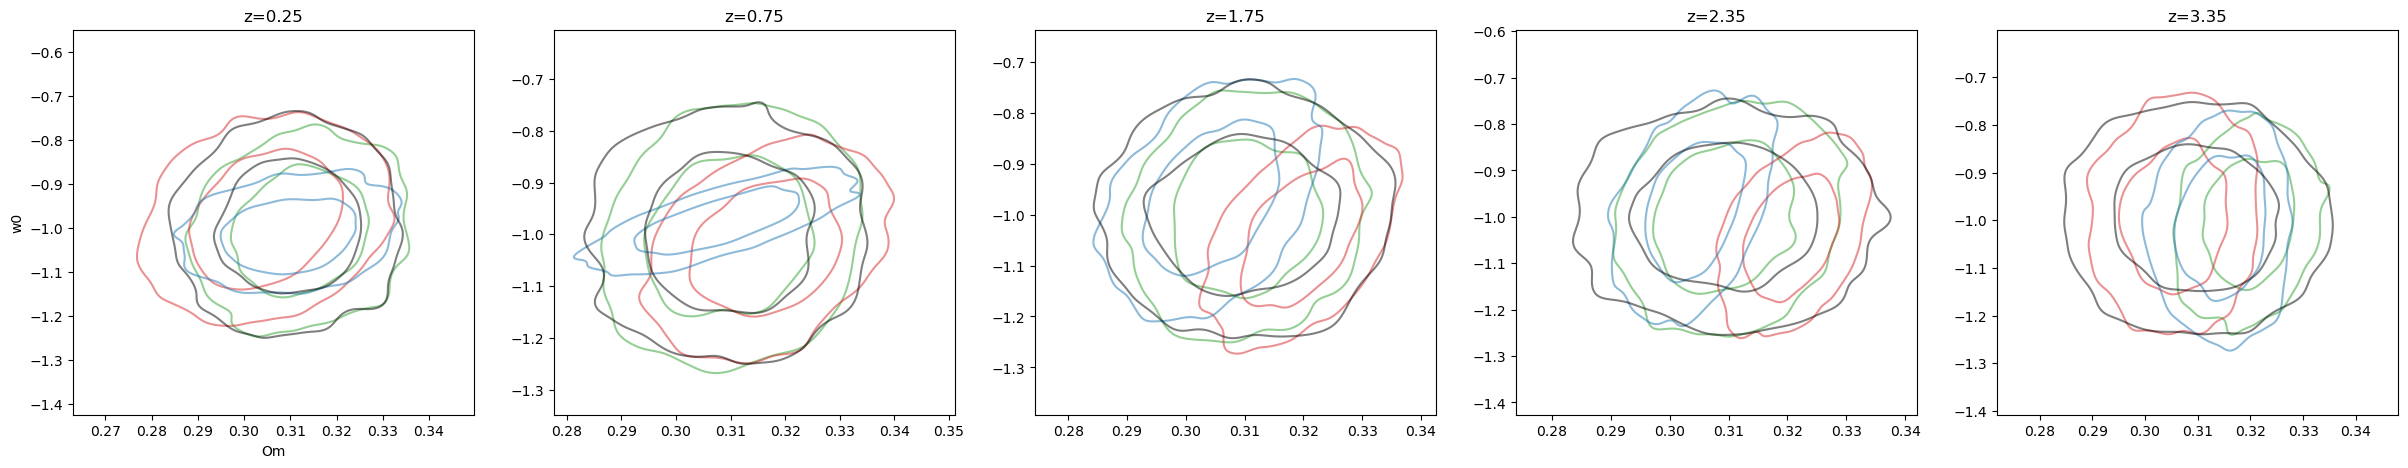

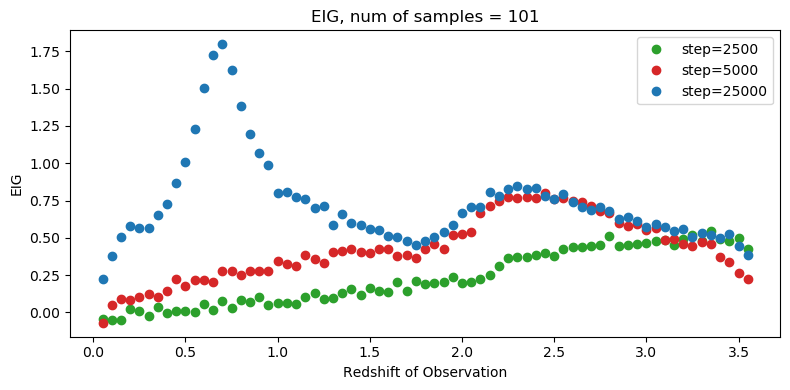

In [14]:
se_l = 0.5 # smoothness parameter
se_sigma = 1.0 # thickness parameter
kernel = GP_Kernels(se_sigma=se_sigma, se_l=se_l).se_kernel
fig1, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
fig2, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
data = torch.tensor([z_1, z_2, y_h1, y_h2, sig_h1, sig_h2], device=device, dtype=torch.float64).reshape(3,2)
GPR_model = GPRegressionModel(data, cosmo.Om0, 0.01, cosmo.w0, 0.1, kernel, "linear", "variable")
steps = 25000
percentiles = [95, 68] # percentiles for contour plot in descending order
measure_designs = torch.tensor([0.25, 0.75, 1.75, 2.35, 3.35], device=device).unsqueeze(-1) # design values for contour plot

train_args = {"observation_labels": ["y"],
            "target_labels": ["Om", "w0"],
            "model": GPR_model.model,
            "steps": steps,
            "n_particles": 101,
            "train_verbose": True, 
            "condition_design": True,
            "device": device}

posterior_flow = flows.conditional_affine_autoregressive(num_transforms, flow_args=flow_args)

pyro.clear_param_store()
optimizer = torch.optim.AdamW(posterior_flow.parameters(), lr=5e-5)
device = train_args["device"]
posterior_flow.to(device)
posterior_flow.train(mode=True)
pyro.set_rng_seed(0)

num_samples = 3001
design_idxs = [5, 23]

history = []
for step in range(train_args["steps"]):
    optimizer.zero_grad()
    agg_loss, loss = posterior_loss(design=designs,
                                    model=train_args["model"],
                                    guide = posterior_flow,
                                    num_particles=train_args["n_particles"],
                                    observation_labels=train_args["observation_labels"],
                                    target_labels=train_args["target_labels"],
                                    evaluation=False,
                                    nflow=True,
                                    condition_design=train_args["condition_design"])
    agg_loss.backward()
    optimizer.step()
    if step == 0:
        verbose_shapes = False

    if step == 2500:
        for i, x in enumerate(measure_designs):
            data = GPR_model.model(lexpand(x.unsqueeze(-1),1))
            sample_context = torch.concat((lexpand(x.unsqueeze(-1),1), data), dim=-1).squeeze(1)
            posterior_samples = posterior_flow._sample(num_samples, context=sample_context).squeeze()

            x_grid, y_grid = np.meshgrid(np.linspace(posterior_samples[:,0].cpu().detach().numpy().min(), posterior_samples[:,0].cpu().detach().numpy().max(), 1000), np.linspace(posterior_samples[:,1].cpu().detach().numpy().min(), posterior_samples[:,1].cpu().detach().numpy().max(), 1000))
            positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

            # make contour plot of prior and posterior samples
            posterior_kde = scipy.stats.gaussian_kde([posterior_samples[:,0].cpu().detach().numpy(), posterior_samples[:,1].cpu().detach().numpy()])
            posterior_z = np.reshape(posterior_kde(positions).T, x_grid.shape)
            contour_levels = get_levels(posterior_z, percentiles)

            axs[i].contour(x_grid, y_grid, posterior_z, levels=contour_levels, colors='tab:green', alpha=0.5)

        with torch.no_grad():
            agg_loss, eigs = posterior_loss(design=designs,
                                            model=train_args["model"],
                                            guide = posterior_flow,
                                            num_particles=2000,
                                            observation_labels=train_args["observation_labels"],
                                            target_labels=train_args["target_labels"],
                                            evaluation=True,
                                            nflow=True,
                                            condition_design=train_args["condition_design"])

        ax.plot(redshifts, eigs.cpu().detach().numpy(), 'o', color="tab:green", label="step={}".format(step))

    if step == 5000:
        for i, x in enumerate(measure_designs):
            data = GPR_model.model(lexpand(x.unsqueeze(-1),1))
            sample_context = torch.concat((lexpand(x.unsqueeze(-1),1), data), dim=-1).squeeze(1)
            posterior_samples = posterior_flow._sample(num_samples, context=sample_context).squeeze()

            x_grid, y_grid = np.meshgrid(np.linspace(posterior_samples[:,0].cpu().detach().numpy().min(), posterior_samples[:,0].cpu().detach().numpy().max(), 1000), np.linspace(posterior_samples[:,1].cpu().detach().numpy().min(), posterior_samples[:,1].cpu().detach().numpy().max(), 1000))
            positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

            # make contour plot of prior and posterior samples
            posterior_kde = scipy.stats.gaussian_kde([posterior_samples[:,0].cpu().detach().numpy(), posterior_samples[:,1].cpu().detach().numpy()])
            posterior_z = np.reshape(posterior_kde(positions).T, x_grid.shape)
            contour_levels = get_levels(posterior_z, percentiles)

            axs[i].contour(x_grid, y_grid, posterior_z, levels=contour_levels, colors='tab:red', alpha=0.5)

        with torch.no_grad():
            agg_loss, eigs = posterior_loss(design=designs,
                                            model=train_args["model"],
                                            guide = posterior_flow,
                                            num_particles=2000,
                                            observation_labels=train_args["observation_labels"],
                                            target_labels=train_args["target_labels"],
                                            evaluation=True,
                                            nflow=True,
                                            condition_design=train_args["condition_design"])

        ax.plot(redshifts, eigs.cpu().detach().numpy(), 'o', color="tab:red", label="step={}".format(step))


    history.append(loss)
    if train_args["train_verbose"] and (step % 20000 == 0):
        print('step: {}, loss: {}'.format(step, agg_loss.item()))

stacked_history = torch.stack(history)
history_array = stacked_history.cpu().detach().numpy()

y_sigmas = GPR_model.y_sigma.mean(axis=0).squeeze().cpu().detach().numpy()

with torch.no_grad():
    agg_loss, eigs = posterior_loss(design=designs,
                                    model=train_args["model"],
                                    guide = posterior_flow,
                                    num_particles=2000,
                                    observation_labels=train_args["observation_labels"],
                                    target_labels=train_args["target_labels"],
                                    evaluation=True,
                                    nflow=True,
                                    condition_design=train_args["condition_design"])

# plot posterior samples for a specific redshift (design) value:
for i, x in enumerate(measure_designs):
    data = GPR_model.model(lexpand(x.unsqueeze(-1),1))
    sample_context = torch.concat((lexpand(x.unsqueeze(-1),1), data), dim=-1).squeeze(1)
    posterior_samples = posterior_flow._sample(num_samples, context=sample_context).squeeze()

    x_grid, y_grid = np.meshgrid(np.linspace(posterior_samples[:,0].cpu().detach().numpy().min(), posterior_samples[:,0].cpu().detach().numpy().max(), 1000), np.linspace(posterior_samples[:,1].cpu().detach().numpy().min(), posterior_samples[:,1].cpu().detach().numpy().max(), 1000))
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

    # make contour plot of prior and posterior samples
    posterior_kde = scipy.stats.gaussian_kde([posterior_samples[:,0].cpu().detach().numpy(), posterior_samples[:,1].cpu().detach().numpy()])
    posterior_z = np.reshape(posterior_kde(positions).T, x_grid.shape)
    contour_levels = get_levels(posterior_z, percentiles)

    axs[i].contour(x_grid, y_grid, posterior_z, levels=contour_levels, colors='tab:blue', alpha=0.5)
    axs[i].set_title("z={}".format(measure_designs[i].item()))

# plot the prior dist
for i in range(5):
    om_prior_samples = dist.Normal(GPR_model.Om_prior, GPR_model.Om_sigma_prior).sample((num_samples,))
    w0_prior_samples = dist.Normal(GPR_model.w0_prior, GPR_model.w0_sigma_prior).sample((num_samples,))

    x_grid, y_grid = np.meshgrid(np.linspace(om_prior_samples.cpu().detach().numpy().min(), om_prior_samples.cpu().detach().numpy().max(), 1000), np.linspace(w0_prior_samples.cpu().detach().numpy().min(), w0_prior_samples.cpu().detach().numpy().max(), 1000))
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    prior_kde = scipy.stats.gaussian_kde([om_prior_samples.cpu().detach().numpy(), w0_prior_samples.cpu().detach().numpy()])
    prior_z = np.reshape(prior_kde(positions).T, x_grid.shape)
    contour_levels = get_levels(prior_z, percentiles)

    axs[i].contour(x_grid, y_grid, prior_z, levels=contour_levels, colors='Black', alpha=0.5)

axs[0].set_xlabel("Om")
axs[0].set_ylabel("w0")
#axs[1].set_title("Posterior Samples at z={}".format(designs[design_idxs[0]].item()))
#axs[2].set_xlabel("Om")
#axs[2].set_ylabel("w0")
#axs[2].set_title("Posterior Samples at z={}".format(designs[design_idxs[1]].item()))     
                
ax.plot(redshifts, eigs.cpu().detach().numpy(), 'o', color="tab:blue", label="step={}".format(steps))
# plot vertical line of the previous measurements
#ax.axvline(x=z_1, color='r', linestyle='--', label="Prior Observations")
#ax.axvline(x=z_2, color='r', linestyle='--', label="Prior Observations")
# add subplot title
ax.set_title('EIG, num of samples = {}'.format(train_args["n_particles"]))


ax.set_xlabel("Redshift of Observation")
ax.set_ylabel("EIG")

ax.legend()
plt.tight_layout()
plt.show()

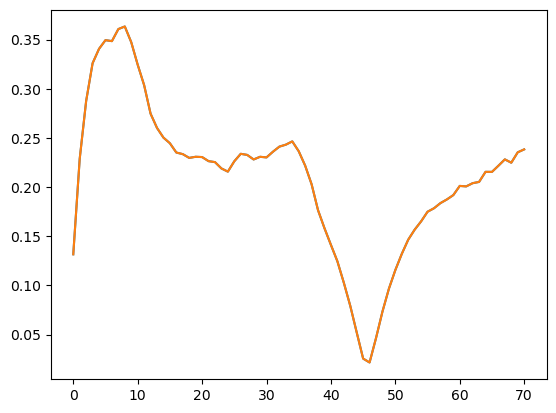

In [19]:
plt.plot(y_sigmas)
plt.show()

step: 0, loss: 357.5077142938218
step: 20000, loss: -329.79673393848196
step: 0, loss: 291.53002184650416
step: 20000, loss: -330.01718975575216
step: 0, loss: 291.5312742884622
step: 20000, loss: -331.19220270460204
step: 0, loss: 291.5299906134593
step: 20000, loss: -333.188078580252


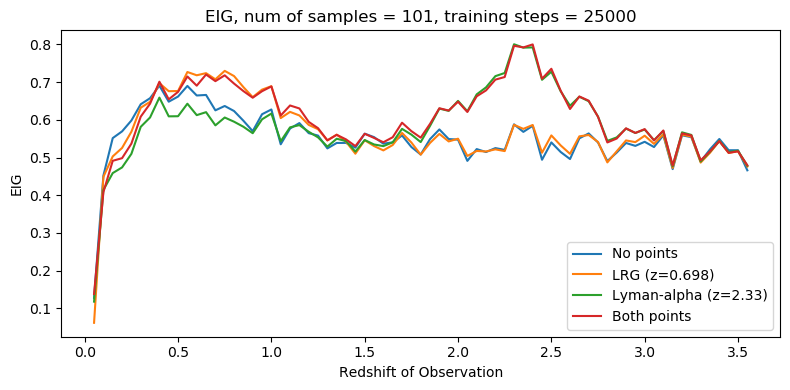

In [20]:
se_l = 0.5 # smoothness parameter
se_sigma = 1.0 # thickness parameter
kernel = GP_Kernels(se_sigma=se_sigma, se_l=se_l).se_kernel
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
data0 = torch.tensor([], device=device, dtype=torch.float64).reshape(3,0)
data1 = torch.tensor([z_1, y_h1, sig_h1], device=device, dtype=torch.float64).reshape(3,1)
data2 = torch.tensor([z_2, y_h2, sig_h2], device=device, dtype=torch.float64).reshape(3,1)
data3 = torch.tensor([z_1, z_2, y_h1, y_h2, sig_h1, sig_h2], device=device, dtype=torch.float64).reshape(3,2)
data_loop = [data0, data1, data2, data3]
data_names = ["No points", "LRG (z=0.698)", "Lyman-alpha (z=2.33)", "Both points"]
steps = 25000

for i, data in enumerate(data_loop):
    GPR_model = GPRegressionModel(data, cosmo.Om0, 0.01, cosmo.w0, 0.1, kernel, "linear", "fixed")
    train_args = {"observation_labels": ["y"],
            "target_labels": ["Om", "w0"],
            "model": GPR_model.model,
            "steps": steps,
            "n_particles": 101,
            "train_verbose": True, 
            "condition_design": True,
            "device": device}
    posterior_flow = flows.conditional_affine_autoregressive(num_transforms, flow_args=flow_args)
    pyro.clear_param_store()
    optimizer = torch.optim.AdamW(posterior_flow.parameters(), lr=5e-5)
    device = train_args["device"]
    posterior_flow.to(device)
    posterior_flow.train(mode=True)
    pyro.set_rng_seed(1)

    num_samples = 3001
    design_idxs = [5, 23]

    history = []
    for step in range(train_args["steps"]):
        optimizer.zero_grad()
        agg_loss, loss = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=train_args["n_particles"],
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=False,
                                        nflow=True,
                                        condition_design=train_args["condition_design"])
        agg_loss.backward()
        optimizer.step()
        if step == 0:
            verbose_shapes = False

        history.append(loss)
        if train_args["train_verbose"] and (step % 20000 == 0):
            print('step: {}, loss: {}'.format(step, agg_loss.item()))

    stacked_history = torch.stack(history)
    history_array = stacked_history.cpu().detach().numpy()

    y_sigmas = GPR_model.y_sigma.mean(axis=0).squeeze().cpu().detach().numpy()

    with torch.no_grad():
        agg_loss, eigs = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=2000,
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=True,
                                        nflow=True,
                                        condition_design=train_args["condition_design"])

    ax.plot(redshifts, eigs.cpu().detach().numpy(), label="{}".format(data_names[i]))

# add subplot title
ax.set_title('EIG, num of samples = {}, training steps = {}'.format(train_args["n_particles"], steps))


ax.set_xlabel("Redshift of Observation")
ax.set_ylabel("EIG")

ax.legend()
plt.tight_layout()
plt.show()